In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import pickle as pkl
import os
import torch
sys.path.append('/extra/yadongl10/BIG_sandbox/SparseImageFlows')
import data_loader
import imp
imp.reload(data_loader)
from torch.distributions import Normal, Bernoulli
import h5py
import numpy as np
import utils
from data_loader import load_LAGAN, load_data_LAGAN
from plot_utils import discrete_mass, discrete_pt, ChiSquareTest
import seaborn as sns

# 1. Transform and create one-hot image dataset

In [12]:
# quantize dataset to [0,1,...,300]
image = load_data_LAGAN(subset='background')  # signal
bins = np.linspace(0,284,285)
inds = np.digitize(image, bins)
quantized_image = np.digitize(image, bins, right=False) - 1

In [69]:
with h5py.File(img_dir+'/lagan_data.h5', 'r') as f:
    samples_lagan = np.asarray(f['lagan_generated_signal_images'])
print('samples lagan shape', samples_lagan.shape)   

samples lagan shape (20000, 25, 25)


In [14]:
# img_dir = "/baldig/physicsprojects/lagan"
# with h5py.File(img_dir + '/discretized_lagan.h5', 'w') as f:
#     f.create_dataset('signal', data=quantized_image)
img_dir = "/baldig/physicsprojects/lagan"
with h5py.File(img_dir + '/discretized_lagan.h5', 'a') as f:
    f.create_dataset('background', data=quantized_image)

In [11]:
image.max(), image.min(), image.mean()

(284.67654, 0.0, 0.44451484)

In [13]:
quantized_image.max(), quantized_image.min(), quantized_image.mean()

(284, 0, 0.41092748520052347)

In [80]:
# check saved data
img_dir = "/baldig/physicsprojects/lagan"
with h5py.File(img_dir + '/discretized_lagan.h5', 'r') as f:
    for i in f:
        print(i)
    image = np.asarray(f['signal'])
image.max()



background
concatenate
signal


In [130]:
masked_image.shape

(10000, 25, 25)

In [141]:
n=10000
masked_image = np.zeros_like(image[:n,:,:])
masked_image[:, 4:21, 4:21] = image[:n, 4:21, 4:21]
# masked_image[:, 17:20, 11:14] = image[:n, 17:20, 11:14]

masked_mass, masked_pt = discrete_mass(masked_image), discrete_pt(masked_image)


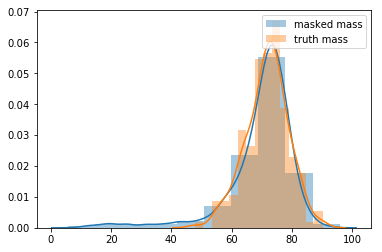

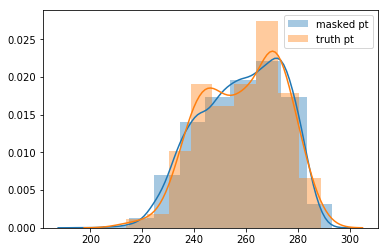

In [142]:
sns.distplot(masked_mass, bins=10, label='masked mass')
sns.distplot(mass,label='truth mass')
plt.legend(loc='upper right')
plt.show()

sns.distplot(masked_pt, bins=10, label='masked pt')
sns.distplot(pt,label='truth pt')
plt.legend(loc='upper right')
plt.show()


In [705]:
mass, pt = discrete_mass(image), discrete_pt(image)
mass.shape, pt.shape, image.shape

In [739]:
mass.max(), pt.max()

(90.321395481534125, 288.91555121839303)

In [719]:
with h5py.File(img_dir + '/discretized_lagan.h5', 'a') as f:
    concatenate = np.concatenate([np.stack([mass, pt],axis=1), image.reshape(-1, 625)], axis=1)
    f.create_dataset('concatenate', data = concatenate)
print(concatenate.shape)

(436333, 627)


# 2. Load trained model

In [6]:
with open(sampledir+'/Mix_discretized_sample_250.pkl', 'rb') as f:
    x = pkl.load(f)
metric = np.asarray(x)[:, :2]
mass_learned = metric[:,0]
pt_learned = metric[:,1]

from scipy.stats import wasserstein_distance
print('learned pt distance', wasserstein_distance(discrete_pt(image[:200]), pt_learned))
print('learned mass distance', wasserstein_distance(discrete_mass(image[:200]), mass_learned))

learned pt distance 2.36305933284
learned mass distance 1.3459274839


(array([  1.,   5.,   8.,  21.,  23.,  55.,  48.,  25.,  11.,   3.]),
 array([ 47.8021283 ,  52.05405502,  56.30598173,  60.55790845,
         64.80983517,  69.06176189,  73.31368861,  77.56561533,
         81.81754204,  86.06946876,  90.32139548]),
 <a list of 10 Patch objects>)

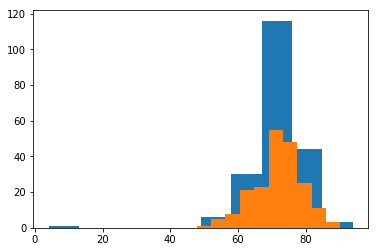

In [806]:
plt.hist(metric[:,0], bins=10)
plt.hist(mass, bins=10)

(array([  2.,   1.,  10.,  30.,  28.,  26.,  25.,  41.,  27.,  10.]),
 array([ 213.55144439,  221.08785507,  228.62426575,  236.16067644,
         243.69708712,  251.2334978 ,  258.76990849,  266.30631917,
         273.84272985,  281.37914054,  288.91555122]),
 <a list of 10 Patch objects>)

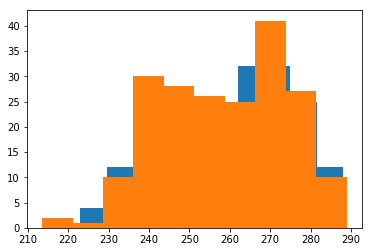

In [807]:
plt.hist(metric[:,1])
plt.hist(pt)

In [5]:
sampledir = '/extra/yadongl10/BIG_sandbox/SparseImageFlows_result/lagan_pixelcnn/Mixture'
with open(sampledir+'/Mix_discretized_sample_250.pkl', 'rb') as f:
    x = pkl.load(f)
sample_sg = np.asarray(x)[:, 2:].reshape(-1, 25, 25)
print(sample_sg.shape)

(200, 25, 25)


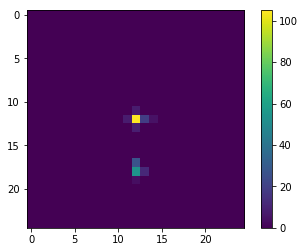

In [49]:
plt.imshow(image[35])
plt.colorbar()


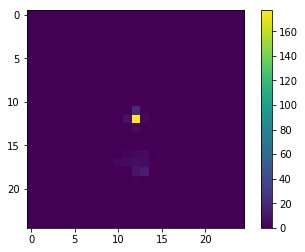

In [55]:
plt.imshow(sample_sg[21])
plt.colorbar()

0.461208
overall sparsity: truth and samples: 0.9709381302812302 0.97096


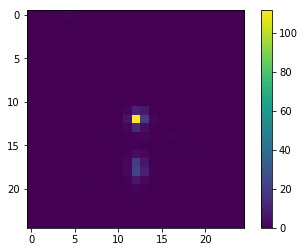

In [814]:
plt.imshow(sample_sg.mean(axis=0))
plt.colorbar()
print(sample_sg.mean())
print('overall sparsity: truth and samples:',
      np.where(image.ravel()==0)[0].shape[0] / image.ravel().shape[0],
      np.where(sample_sg.ravel()==0)[0].shape[0] / sample_sg.ravel().shape[0])

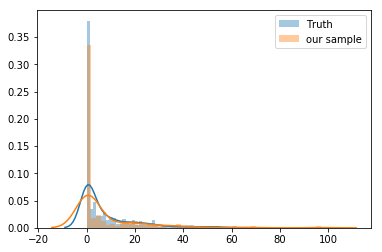

In [112]:
import seaborn as sns 
x=19
y=12

pixel_bg = sample_sg[:,x,y]
pixel = image[:1000,x,y]
x = np.linspace(0.0,200,1000)
sns.distplot(pixel, label='Truth', bins=50)
sns.distplot(pixel_bg, label='our sample', bins=50)
plt.legend()


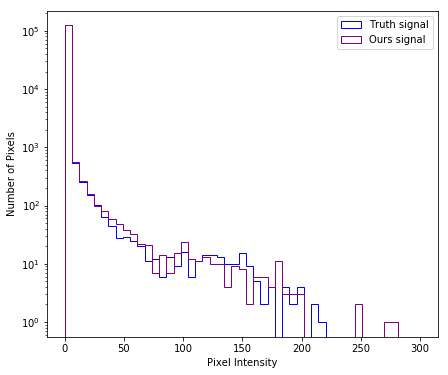

In [46]:
fig, ax = plt.subplots(figsize=(7, 6))

_, bins, _ = plt.hist(image[:200].ravel(), 
           bins=np.linspace(0,300,50), histtype='step', label='Truth signal', color='blue')

_, bins, _ = plt.hist(sample_sg.ravel(),  # to make sure have same amount of samples
           bins=np.linspace(0,300,50), histtype='step', label='Ours signal', color='purple')


plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper right')

# 3. Transform generated one-hot image to real value

# 4. Compare statistics (mass, pt)

In [118]:
bins = 10
n = 200
# real image
mass, pt = discrete_mass(image[2*n:3*n]), discrete_pt(image[2*n:3*n])
chi2 = ChiSquareTest(bins=bins, truth=(mass, pt))
count_truth = chi2.expectation

# ours 
mass_ours, pt_ours = discrete_mass(masked_image), discrete_pt(masked_image)
distance_ours, count_ours = chi2.getChisquare((mass_ours, pt_ours)) #mass_learned, pt_learned

# 
mass_lagan, pt_lagan = discrete_mass(samples_lagan[:n]), discrete_pt(samples_lagan[:n])
distance_lagan, count_lagan = chi2.getChisquare((mass_lagan, pt_lagan))
print(distance_ours, distance_lagan) 

print('learned pt distance', wasserstein_distance(discrete_pt(image[:200]), pt_ours))
print('learned mass distance', wasserstein_distance(discrete_mass(image[:200]), mass_ours))

3326674546.58 674.408485958
learned pt distance 26.664325326
learned mass distance 14.866140266


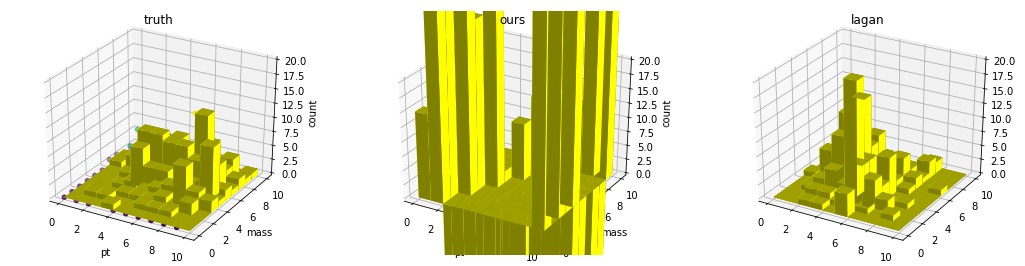

In [119]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18, 4.5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

_x = np.arange(bins)
_y = np.arange(bins)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
bottom = np.zeros_like(x)
width = depth = 1

ax1.scatter(x,y,count_truth.ravel(), c=count_truth.ravel())
ax1.bar3d(x, y, bottom, width, depth, count_truth.ravel(), color="yellow")
ax2.bar3d(x, y, bottom, width, depth, count_ours.ravel(), color="yellow")
ax3.bar3d(x, y, bottom, width, depth, count_lagan.ravel(), color="yellow")

ax1.set_title('truth')
ax2.set_title('ours')
ax3.set_title('lagan')

for ax in [ax1, ax2]:
    ax.set_zlim((0,20))
    ax.set_xlabel('pt')
    ax.set_ylabel('mass')
    ax.set_zlabel('count')

plt.show()

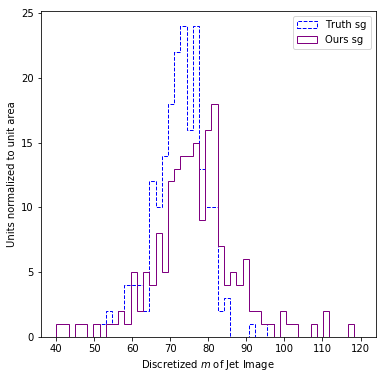

In [819]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(40, 120, 50)
mass_image, _, _ = plt.hist(discrete_mass(image[:200]), 
             bins=bins, histtype='step', label=r'Truth sg', normed=False, color='blue', linestyle='dashed')
mass_samples, _, _ = plt.hist(discrete_mass(sample_sg), 
             bins=bins, histtype='step', label=r'Ours sg', normed=False, color='purple', linestyle='solid')
# mass_lagan, _, _ = plt.hist(discrete_mass(samples_lagan), 
#              bins=bins, histtype='step', label=r'LAGAN sg', normed=False, color='green', linestyle='solid')
plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()
# plt.ylim(0, 0.11)


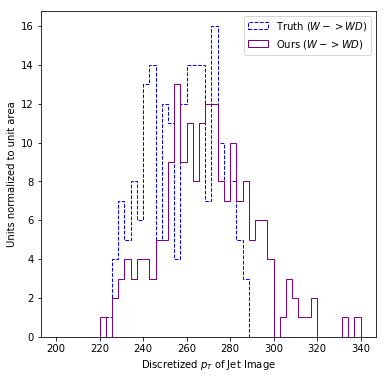

In [820]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(200, 340, 50)

pt_image, _, _ = plt.hist(discrete_pt(image[:200]), 
             bins=bins, histtype='step', label=r'Truth ($W->WD$)', normed=False, color='blue', linestyle='dashed')
pt_samples, _, _ = plt.hist(discrete_pt(sample_sg), 
             bins=bins, histtype='step', label=r'Ours ($W->WD$)', normed=False, color='purple')
plt.xlabel(r'Discretized $p_T$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()
# plt.ylim(0, 0.045)


In [ ]:
import 